This notebook contains the second Coffee-Grading Model, which will know classify beans into 4 categories, imitating the original taks even closer.

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

Model 1. Regular CNN. Similar to the model that works with 2 classes, yet this one has 4.

In [2]:
data_dir = 'data'
print(os.listdir(data_dir))

['defect', 'longberry', 'peaberry', 'premium']


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Sub-Model1

In [4]:
data = tf.keras.utils.image_dataset_from_directory('data') # Here, we load the data from the directory

Found 8000 files belonging to 4 classes.


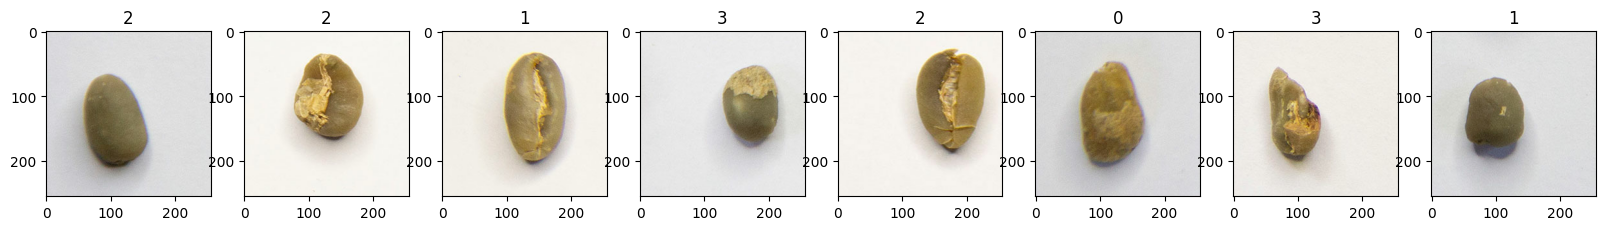

In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=8, figsize=(20,20)) 
for idx, img in enumerate(batch[0][8:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
def normalize(x, y):
    return x / 255, y

data = data.map(normalize)

In [7]:
total_size = len(data)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
test_size = total_size - train_size - val_size

In [8]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
len(train)

175

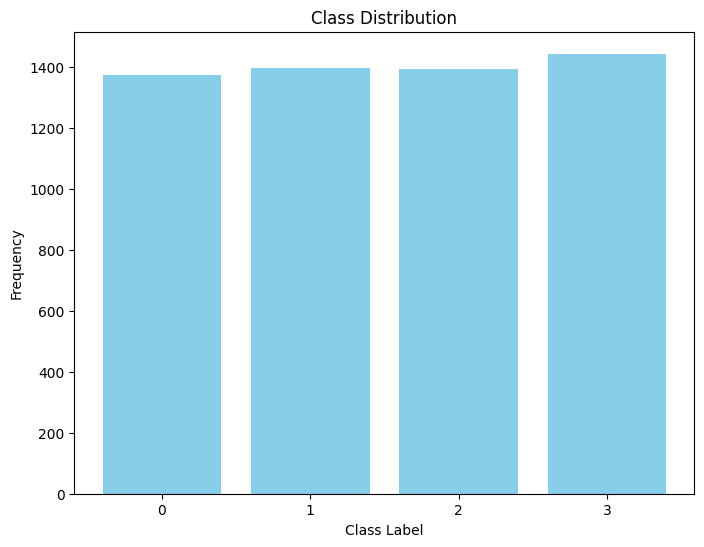

Class 0: 1372 samples
Class 1: 1394 samples
Class 2: 1392 samples
Class 3: 1442 samples


In [51]:
import matplotlib.pyplot as plt

# Define a function to separate features and labels
def separate_features_and_labels(features, label):
    return features, label

# Apply the function to each element of the dataset to separate features and labels
train_features_and_labels = train.map(separate_features_and_labels)


# Extract features and labels into separate lists
train_features = []
train_labels = []

for features, label in train_features_and_labels:
    train_features.append(features)
    train_labels.append(label)

# Convert lists to NumPy arrays if needed
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# Assuming 'y' contains the class labels
class_labels, class_counts = np.unique(train_labels, return_counts=True)

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(class_labels)
plt.show()

# Print class frequencies
for label, count in zip(class_labels, class_counts):
    print(f'Class {label}: {count} samples') 

# Class distribution is rather equal.

In [9]:
model = Sequential()
model.add(Conv2D(32, (2, 2), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2, 2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (2, 2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Changing to 4 for four classes and using softmax

In [10]:
# Compile the model with the updated loss function
learning_rate = 0.0005  
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0

In [11]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [12]:
# hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [13]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)  # Convert predictions to label indices
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

In [ ]:
print(precision.result().numpy(), recall.result().numpy(), accuracy.result().numpy())

In [ ]:
model.save(os.path.join('models','CoffeeModel2.h5'))

Model 2.  Residual Neural Network. Residual neural network will allow us to create a tryly deep neural network with many layers, which will still be susceptible to training, because it is, well, residual.

In [14]:
def residual_block(x, filters, kernel_size=3, stride=1):
    x_og = x
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x) 
    # Batch normalization helps prevent Internal Covariate Shift by normalizing the data.
    # After normalization, the normalized activations are scaled and shifted using learnable parameters γ and 𝛽
    # Also, Batch Normalization reduces this dependency, making the training process less sensitive 
    # to the initial starting conditions.
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != x_og.shape[-1]: # In case the shape of the output of the block is different from the input one
        x_og = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal')(x_og)
        x_og = layers.BatchNormalization()(x_og)
    
    x = layers.add([x, x_og]) # Here we add the input to the output of a block. 
    x = layers.ReLU()(x)
    
    return x

In [15]:
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    
    return model


In [16]:
input_shape = (256, 256, 3)  
num_classes = 4

model = build_resnet(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d_3[0][0]']               
 alization)                     )                                                             

In [17]:
logdir='logs2'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
def one_hot_encode(data, label):
    num_classes = 4  # Set this to the number of classes in your dataset
    label = tf.one_hot(label, num_classes)  # Subtract 1 to make labels zero-based for one-hot encoding
    return data, label


In [19]:
one_hot_train = train.map(one_hot_encode)
one_hot_valid = val.map(one_hot_encode)
one_hot_test = test.map(one_hot_encode)

In [20]:
for data, label in one_hot_test.take(1):
    print("Data shape:", data.shape)
    print("Label shape:", label.shape)
    print("Label:", label.numpy())

Data shape: (32, 256, 256, 3)
Label shape: (32, 4)
Label: [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [21]:
hist2 = model.fit(one_hot_train, epochs=30, validation_data=one_hot_valid, callbacks=[tensorboard_callback], batch_size=48)

# Best Accuracy = 0.98, Val_Ac=0.84

Epoch 1/30
175/175 [==============================] - 59s 261ms/step - loss: 0.6924 - accuracy: 0.7370 - val_loss: 7.1842 - val_accuracy: 0.2962
Epoch 2/30
175/175 [==============================] - 45s 260ms/step - loss: 0.4490 - accuracy: 0.8314 - val_loss: 0.8916 - val_accuracy: 0.6806
Epoch 3/30
175/175 [==============================] - 46s 265ms/step - loss: 0.3675 - accuracy: 0.8695 - val_loss: 2.2140 - val_accuracy: 0.4875
Epoch 4/30
175/175 [==============================] - 46s 263ms/step - loss: 0.3329 - accuracy: 0.8750 - val_loss: 1.5008 - val_accuracy: 0.6594
Epoch 5/30
175/175 [==============================] - 46s 263ms/step - loss: 0.2827 - accuracy: 0.8995 - val_loss: 0.7801 - val_accuracy: 0.6975
Epoch 6/30
175/175 [==============================] - 46s 264ms/step - loss: 0.2401 - accuracy: 0.9170 - val_loss: 4.6499 - val_accuracy: 0.3063
Epoch 7/30
175/175 [==============================] - 46s 264ms/step - loss: 0.2331 - accuracy: 0.9155 - val_loss: 1.0391 - val_ac

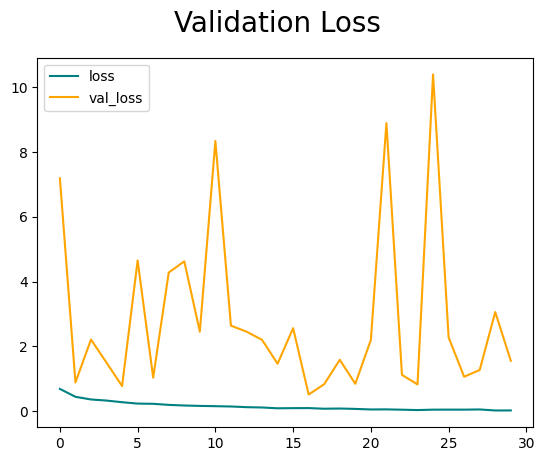

In [22]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

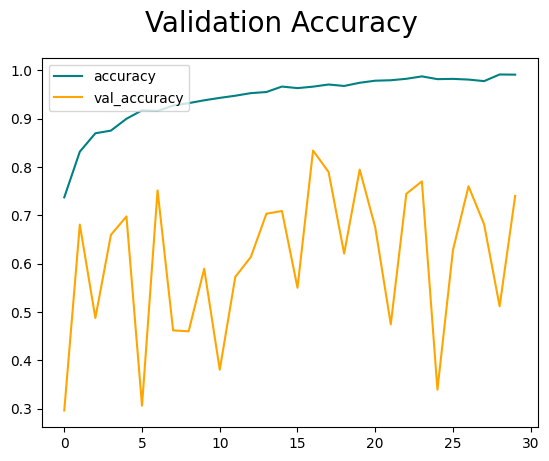

In [23]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [46]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

count = 0
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)  # Convert predictions to label indices
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    if count < 5:
        print(yhat[:8])
        print(y[:8])
        count += 1
    accuracy.update_state(y, yhat)

print("Precision: " + str(precision.result().numpy()), "\nRecall: " + str(recall.result().numpy()) + "\nAccuracy:" + str(accuracy.result().numpy()))

1/1 [==============================] - 0s 40ms/step
tf.Tensor([1 0 0 2 2 1 2 0], shape=(8,), dtype=int64)
[1 0 0 2 3 1 2 0]
1/1 [==============================] - 0s 36ms/step
tf.Tensor([1 1 3 1 2 1 0 1], shape=(8,), dtype=int64)
[1 1 3 1 2 1 0 3]
1/1 [==============================] - 0s 30ms/step
tf.Tensor([1 1 1 0 1 2 1 0], shape=(8,), dtype=int64)
[0 1 1 0 1 0 3 0]
1/1 [==============================] - 0s 31ms/step
tf.Tensor([2 2 1 2 2 3 2 1], shape=(8,), dtype=int64)
[2 2 1 2 3 3 2 1]
1/1 [==============================] - 0s 27ms/step
tf.Tensor([0 1 1 0 1 2 1 3], shape=(8,), dtype=int64)
[0 3 1 0 1 2 0 3]
1/1 [==============================] - 0s 25ms/step
Precision: 0.8951368 
Recall: 0.99325466
Accuracy:0.28


In [28]:
model.save(os.path.join('models','CoffeeModel3v2.h5'))

At first, the model did well to decrease the loss and improve the accuracy, yet did terrible in terms of decreasing validation loss and increasing validation accuracy

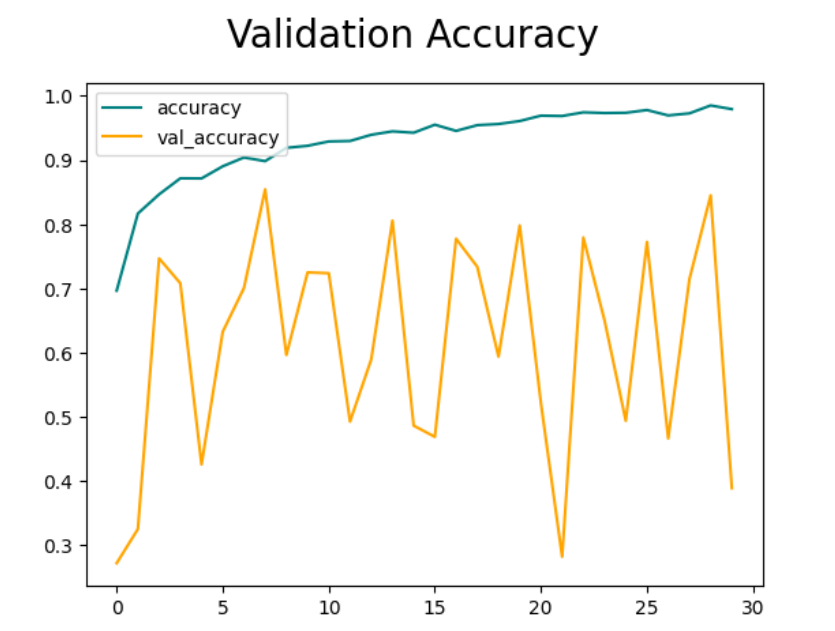

In [31]:
from IPython.display import Image
Image(filename='pictures/val_accv1.png', width=400)

Then, upon increasing the batch size, thus making model updates less noisy, and decreasing learning rate, the train loss greatly reduced and train accuracy greatly increased, and so did validation compatriots, yet validation metrics remained somewhat jumping. During training it became appraent that 30 epochs is too much, as the model starts tio overfit afterwards. 

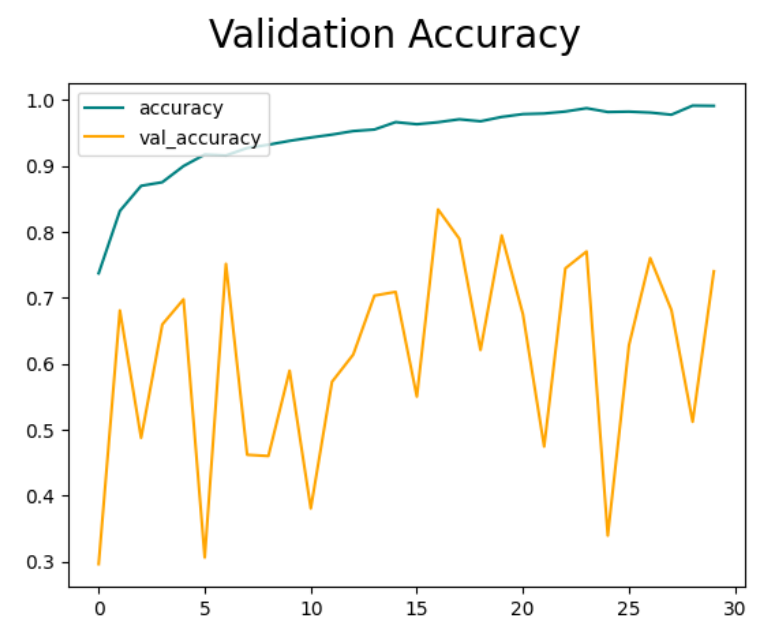

In [32]:
Image(filename='pictures/val_accv2.png', width=400)

As you can see, our improvements didn't turn the world upside down, nor did they heal our model. 